# Masking Methods for Time Series
This notebook, designed for Google Colab, showcases various masking methods for time series data with the mask_in_model approach. 
Additional models are included, such as Ensemble models.
The masking of the input will be executed within the train_model function. 


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def random_masking(x, mask_ratio,forecasting_ratio=0.25,forecast_steps=10):
    """
    Perform per-sample random masking by per-sample shuffling.
    Per-sample shuffling is done by argsort random noise.
    x: [N, L, D], sequence
    """
    N, L, D = x.shape  # batch, length, dim
    len_keep = int(L * (1 - mask_ratio))
    noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]
    if forecasting_ratio:
        n_forecast_batches = int(N*forecasting_ratio)
        noise[-n_forecast_batches:,-(len_keep + forecast_steps):-forecast_steps ] -= 1.

    # sort noise for each sample
    ids_shuffle = torch.argsort(
        noise, dim=1
    )  # ascend: small is keep, large is remove
    ids_restore = torch.argsort(ids_shuffle, dim=1)

    # keep the first subset
    ids_keep = ids_shuffle[:, :len_keep]
    x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

    # generate the binary mask: 0 is keep, 1 is remove
    mask = torch.ones([N, L], device=x.device)
    mask[:, :len_keep] = 0
    # unshuffle to get the binary mask
    mask = torch.gather(mask, dim=1, index=ids_restore)
    mask = 1 - mask # change: 1 is keep, 0 is remove
    x_masked = x * mask.unsqueeze(-1)
    return x_masked, mask

In [ ]:
def patch_masking(x, mask_ratio, patch_size=10):
    """
    Perform per-sample random masking by creating non-overlapping patches.

    Args:
        x (torch.Tensor): Input tensor of shape [N, L, D].
        mask_ratio (float): Proportion of elements to mask.
        patch_size (int): Size of non-overlapping patches to create.

    Returns:
        tuple: (x_masked, mask) where x_masked is the masked input tensor and mask is the binary mask.
    """
    N, L, D = x.shape  # batch size, sequence length, dimension
    len_keep = int(L * (1 - mask_ratio))
    all_masked = (L - len_keep) // patch_size
    # Create a list to store masks for each sample
    batch_masks = []
    # For each sample
    for i in range(N):
        # Create a 1 tensor for the current sample's first channel
        mask_patches = torch.ones_like(x[i, :, 0])

        # Flatten the tensor into a 1D array
        flat_mask = mask_patches.flatten()

        # Convert to numpy array
        flat_mask_np = flat_mask.cpu().numpy()

        # Start at a random position
        # current_i = np.random.randint(0, L//2)
        current_i = np.random.randint(0, L)
        patches_applied = 0
        mask_chance = 0.5 # allows to adjust the chane of non masking between patches
        while patches_applied < all_masked:
            if np.random.rand() < mask_chance:
                # Mask the next patch_size elements
                end = min(current_i + patch_size, len(flat_mask_np))
                #add missing patches to beginn
                if end == len(flat_mask_np):
                    flat_mask_np[0:patch_size] = 0
                    patches_applied += 1
                    current_i = patch_size

                else:
                    # Mask the current position
                    flat_mask_np[current_i] = 0
                    # Mask the end positions
                    flat_mask_np[current_i:end] = 0
                    # Move to the end of the current patch
                    current_i = end
                    patches_applied += 1
            else:
                # Move to the next position
                current_i += 1

        print(f"patch applied {patches_applied} in batch {i} times with patch size {patch_size}. Keeping {len_keep} values out of {L}")
        # Convert back to torch tensor and reshape
        mask = torch.from_numpy(flat_mask_np).to(x.device)
        mask = mask.view_as(mask_patches)
        mask = mask.unsqueeze(-1)
        batch_masks.append(mask)

    # Stack all masks into a batch
    mask = torch.stack(batch_masks, dim=0)

    # Apply the mask to the input tensor 0 is removed elements and 1 keep, we remove mask ratio elements
    x_masked = x * mask
    mask = mask.squeeze(-1)
    return x_masked, mask

# Create Sinusoidal Sequence for Testing

This function creates a time series with sinusoidal patterns for each feature. The sinusoidal frequency increases
with each subsequent feature, simulating different variates in a time series setting.


In [ ]:
def create_sinusoidal_sequence(batch_size: int = 32, sequence_length: int = 100, frequency: float = 1.0, n_features: int = 2, device: str = 'mps' if torch.backends.mps.is_available() else 'cpu') -> torch.Tensor:
    """
    Creates a sinusoidal sequence for testing.

    Args:
        batch_size (int): Number of samples in the batch.
        sequence_length (int): Length of the sequence.
        frequency (float): Frequency of the sinusoid.
        n_features (int): Number of features in the sequence.
        device (str): Device to create the tensor on.

    Returns:
        torch.Tensor: A tensor of shape [batch_size, sequence_length, n_features] representing the sinusoidal sequence.
    """
    device = torch.device(device)
    time_points = torch.linspace(0, 2 * np.pi, sequence_length, device=device)
    freq=2
    if n_features == 1:
        signal = torch.sin(frequency * time_points)
    else:
        features = []
        for i in range(n_features):
            if i == 0:
                feat = torch.sin(frequency * time_points)
            else:
                feat = torch.cos(frequency * freq * time_points)
                freq  += 1
            features.append(feat)
        signal = torch.stack(features, dim=1)

    signal = signal.unsqueeze(0)
    sequence = signal.repeat(batch_size, 1, 1)

    sequence = (sequence - sequence.mean(dim=1, keepdim=True)) / (sequence.std(dim=1, keepdim=True) + 1e-8)

    return sequence

# Create Model


In [ ]:
class BaseModel(nn.Module):
    def __init__(
        self, input_sequence_length: int, output_sequence_length: int, num_features: int
    ) -> None:
        super(BaseModel, self).__init__()
        self.input_sequence_length = input_sequence_length
        self.output_sequence_length = output_sequence_length
        self.num_features = num_features

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        raise NotImplementedError()


# Basic Autoencoder

In [ ]:
class AutoLin_Masking(BaseModel):
    def __init__(self, input_sequence_length: int, output_sequence_length: int, num_features: int):
        super(AutoLin_Masking, self).__init__(input_sequence_length, output_sequence_length, num_features)
        # Encoder layers
        self.encoder_layers = nn.ModuleList([
            nn.Linear(self.input_sequence_length, 2048),
            nn.Linear(2048, 512),

        ])
        # Decoder layers
        self.decoder_layers = nn.ModuleList([
            nn.Linear(512, 2048),
        ])
        self.seq_decoder = nn.Linear(2048, self.input_sequence_length)

    def encoder_forward(self, x):
        # Apply encoder layers
        for layer in self.encoder_layers:
            x = layer(x)
        return x

    def decoder_forward(self, x):
        # Apply decoder layers
        for layer in self.decoder_layers:
            x = layer(x)
        return x

    def forward(self, x):
        # Encode the input sequence
        x = x.transpose(1, 2)
        encoder_output = self.encoder_forward(x)
        # Decoder pass
        decoder_output = self.decoder_forward(encoder_output)

        # Final dense layer for output
        decoder_output = self.seq_decoder(decoder_output)
        decoder_output = decoder_output.transpose(1, 2)

        return decoder_output

# Enhanced Autoencoder

In [ ]:
class AutoLin_Masking_Relu(BaseModel):
    def __init__(self, input_sequence_length: int, output_sequence_length: int, num_features: int):
        super(AutoLin_Masking_Relu, self).__init__(input_sequence_length, output_sequence_length, num_features)
        # Encoder layers
        self.encoder_layers = nn.ModuleList([
            nn.Linear(self.input_sequence_length, 2048),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(1024, 512),
        ])
        # Decoder layers
        self.decoder_layers = nn.ModuleList([
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(1024, 2048),
        ])
        self.seq_decoder = nn.Linear(2048, self.input_sequence_length)

    def encoder_forward(self, x):
        # Apply encoder layers
        for layer in self.encoder_layers:
            x = layer(x)
        return x

    def decoder_forward(self, x):
        # Apply decoder layers
        for layer in self.decoder_layers:
            x = layer(x)
        return x

    def forward(self, x):
        # Encode the input sequence
        x = x.transpose(1, 2)
        encoder_output = self.encoder_forward(x)
        # Decoder pass
        decoder_output = self.decoder_forward(encoder_output)

        # Final dense layer for output
        decoder_output = self.seq_decoder(decoder_output)
        decoder_output = decoder_output.transpose(1, 2)

        return decoder_output

# Ensemble test
just averaging the outputs of each model

In [ ]:
class EnsembleModel(BaseModel):
    def __init__(self, input_sequence_length: int, output_sequence_length: int, num_features: int):
        super(EnsembleModel, self).__init__(input_sequence_length, output_sequence_length, num_features)

        # Initialize both models
        self.model1 = AutoLin_Masking(input_sequence_length, output_sequence_length, num_features)
        self.model2 = AutoLin_Masking_Relu(input_sequence_length, output_sequence_length, num_features)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Get predictions from both models
        output1 = self.model1(x)
        output2 = self.model2(x)
        # Simple averaging of the outputs
        ensemble_output = (output1 + output2) / 2

        return ensemble_output

In [ ]:
class EnsembleModel(BaseModel):
    def __init__(self, input_sequence_length: int, output_sequence_length: int, num_features: int):
        super(EnsembleModel, self).__init__(input_sequence_length, output_sequence_length, num_features)

        # Initialize both models
        self.model1 = AutoLin_Masking(input_sequence_length, output_sequence_length, num_features)
        self.model2 = AutoLin_Masking_Relu(input_sequence_length, output_sequence_length, num_features)
        self.final_layer = nn.Linear(self.input_sequence_length, self.input_sequence_length)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Get predictions from both models
        output1 = self.model1(x)
        output2 = self.model2(x)
        # output3 = self.model3(x)
        # output4 = self.model4(x)
        # Simple averaging of the outputs
        ensemble_output = (output1 + output2) / 2
        ensemble_output = ensemble_output.transpose(1, 2)

        # Pass through the final fc layer
        final_output = self.final_layer(ensemble_output)
        return final_output.transpose(1, 2)

# Ensemble with CAT test

In [ ]:
class EnsembleModel2(BaseModel):
    def __init__(self, input_sequence_length: int, output_sequence_length: int, num_features: int):
        super(EnsembleModel2, self).__init__(input_sequence_length, output_sequence_length, num_features)

        # Initialize both models
        self.model1 = AutoLin_Masking(input_sequence_length, output_sequence_length, num_features)
        self.model2 = AutoLin_Masking_Relu(input_sequence_length, output_sequence_length, num_features)
        # Adjust the final layer to handle the concatenated features
        self.final_layer = nn.Linear(2 * num_features, num_features)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Get predictions from both models
        output1 = self.model1(x)
        output2 = self.model2(x)

        # Concatenate the outputs along the feature dimension (dim=2)
        ensemble_output = torch.cat([output1, output2], dim=2)

        # Pass through the final fc layer
        final_output = self.final_layer(ensemble_output)
        return final_output

# Train Model
- loss.backward can be adjusted for example only seen areas
- the masking algorithm and hyperparameters can be changed for training

In [ ]:
def reconstruction_loss(x, reconstructed_x, mask, loss_fn, alpha=0):
    """
    Computes the reconstruction loss, applying loss only to masked positions,
    with optional monitoring of loss on visible positions.

    Args:
        x (torch.Tensor): Original input tensor of shape [batch_size, seq_len, num_features].
        reconstructed_x (torch.Tensor): Model's reconstructed input tensor, same shape as x.
        mask (torch.Tensor): Binary mask of shape [batch_size, seq_len, num_features] where 1 indicates the position was visible (unmasked) and 0 indicates it was masked.
        loss_fn (callable): Loss function, e.g., nn.MSELoss(reduction='none').
        alpha (float, optional): Weighting factor for the loss on visible positions. Defaults to 0.5.

    Returns:
        tuple: (loss_removed, loss_seen, total_loss)
    """
    loss_fn = nn.MSELoss(reduction='none')  # Use per-element loss
    # Compute element-wise loss between reconstructed and original input
    loss_values = loss_fn(reconstructed_x, x)  # Shape: [batch_size, seq_len, num_features]

    # Calculate loss only on masked (removed) positions
    loss_removed = (loss_values * (1 - mask)).sum() / ((1 - mask).sum())

    # Calculate loss on observed (seen) positions for monitoring
    loss_seen = (loss_values * mask).sum() / (mask.sum())

    # Combine losses with weighting factor alpha for seen loss
    total_loss = loss_removed + alpha * loss_seen

    return loss_removed, loss_seen, total_loss

def train_model(model, x_masked, x_original, mask, epochs=100, learning_rate=0.001):
    # Define loss function and optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    # Move data to device
    x_masked = x_masked.to(next(model.parameters()).device)
    x_original = x_original.to(next(model.parameters()).device)
    best_loss = float('inf')
    # Training loop
    for epoch in range(epochs):
        # Forward pass
        outputs = model(x_masked)
        loss_fn = nn.MSELoss(reduction='none')  # Use per-element loss

        loss_removed, loss_seen, total_loss = reconstruction_loss(x_original, outputs, mask, loss_fn, 0.5)

        # Backward pass and optimize
        optimizer.zero_grad()

        # diffrent losses for testing, select 1
        # loss_removed.backward()
        # loss_seen.backward()
        total_loss.backward()
        optimizer.step()
        if total_loss < best_loss:
            best_loss = total_loss
            best_model = model
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss.item():.6f}')

    return best_model

# Example usage
if __name__ == "__main__":
    # Create data
    batch_size = 2
    sequence_length = 512
    epochs=100
    num_features = 25
    device = 'mps' if torch.backends.mps.is_available() else 'cpu'
    x = create_sinusoidal_sequence(batch_size=batch_size, sequence_length=sequence_length, n_features=num_features, device=device)

    #set masking algorithm
    x_masked, mask = patch_masking(x, mask_ratio=0.75, patch_size= 26)
    # x_masked, mask = random_masking(x, mask_ratio=0.75, forecast_steps=720)

    mask = mask.unsqueeze(-1)
    # Initialize model
    model = AutoLin_Masking(input_sequence_length=sequence_length, output_sequence_length=sequence_length, num_features=num_features)
    model2 = AutoLin_Masking_Relu(input_sequence_length=sequence_length, output_sequence_length=sequence_length, num_features=num_features)
    ensemble_model = EnsembleModel(input_sequence_length=sequence_length, output_sequence_length=sequence_length, num_features=num_features)
    ensemble_model2 = EnsembleModel2(input_sequence_length=sequence_length, output_sequence_length=sequence_length, num_features=num_features)


patch applied 14 in batch 0 times with patch size 26. Keeping 128 values out of 512
patch applied 14 in batch 1 times with patch size 26. Keeping 128 values out of 512


In [ ]:
# Train model
print("Training ensemble model...")
trained_ensemble_model = train_model(ensemble_model, x_masked, x, mask, epochs=epochs, learning_rate=0.0005)
print("done\n")
print("Training ensemble model 2...")
trained_ensemble_model = train_model(ensemble_model2, x_masked, x, mask, epochs=epochs, learning_rate=0.0005)
print("done\n")

Training ensemble model...
Epoch [10/100], Loss: 21.811356
Epoch [20/100], Loss: 8.791556
Epoch [30/100], Loss: 2.473016
Epoch [40/100], Loss: 0.880870
Epoch [50/100], Loss: 0.602840
Epoch [60/100], Loss: 0.408325
Epoch [70/100], Loss: 0.334774
Epoch [80/100], Loss: 0.322155
Epoch [90/100], Loss: 0.405983
Epoch [100/100], Loss: 0.300085
done

Training ensemble model 2...
Epoch [10/100], Loss: 22.102633
Epoch [20/100], Loss: 10.903687
Epoch [30/100], Loss: 5.255029
Epoch [40/100], Loss: 1.991038
Epoch [50/100], Loss: 0.773303
Epoch [60/100], Loss: 0.529179
Epoch [70/100], Loss: 0.340232
Epoch [80/100], Loss: 0.271682
Epoch [90/100], Loss: 0.223705
Epoch [100/100], Loss: 0.255024
done



In [ ]:
print("Training model...")
trained_model = train_model(model, x_masked, x, mask, epochs=epochs, learning_rate=0.0005)
print("done\n")
print("Training model2 with relu and added layers...")
trained_relu_model = train_model(model2, x_masked, x, mask, epochs=epochs, learning_rate=0.0005)
print("done\n")

Training model...
Epoch [10/100], Loss: 16.764927
Epoch [20/100], Loss: 10.966594
Epoch [30/100], Loss: 8.274499
Epoch [40/100], Loss: 7.093600
Epoch [50/100], Loss: 6.480155
Epoch [60/100], Loss: 5.799354
Epoch [70/100], Loss: 5.472924
Epoch [80/100], Loss: 5.303290
Epoch [90/100], Loss: 5.200258
Epoch [100/100], Loss: 4.994321
done

Training model2 with relu and added layers...
Epoch [10/100], Loss: 27.354725
Epoch [20/100], Loss: 8.435804
Epoch [30/100], Loss: 1.491329
Epoch [40/100], Loss: 0.825810
Epoch [50/100], Loss: 0.806132
Epoch [60/100], Loss: 0.628528
Epoch [70/100], Loss: 0.615734
Epoch [80/100], Loss: 0.554604
Epoch [90/100], Loss: 0.577586
Epoch [100/100], Loss: 0.628949
done



In [ ]:
# class EnsembleModelTest(nn.Module):
#     def __init__(self, modelA, modelB):
#         super().__init__()
#         self.modelA = modelA
#         self.modelB = modelB
#         self.final_layer = nn.Linear(2 * num_features, num_features)

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         # Get predictions from both models
#         output1 = self.modelA(x)
#         output2 = self.modelB(x)

#         # Concatenate the outputs along the feature dimension (dim=2)
#         ensemble_output = torch.cat([output1, output2], dim=2)
#         print(f"ensemble_output cat: {ensemble_output.shape}")
#         # Pass through the final fc layer
#         final_output = self.final_layer(ensemble_output)
#         print(f"final_output: {final_output.shape}")
#         return final_output

In [ ]:
# ensemble_model3 = EnsembleModelTest(trained_model, trained_relu_model)

# for param in trained_model.parameters():
#     param.requires_grad = False

# for param in trained_relu_model.parameters():
#     param.requires_grad = False

# print("Training ensemble model 3...")
# trained_ensemble_model3 = train_model(ensemble_model3, x_masked, x, mask, epochs=epochs, learning_rate=0.0005)
# print("done\n")

# Trained Model Plot Basic Autoencoder

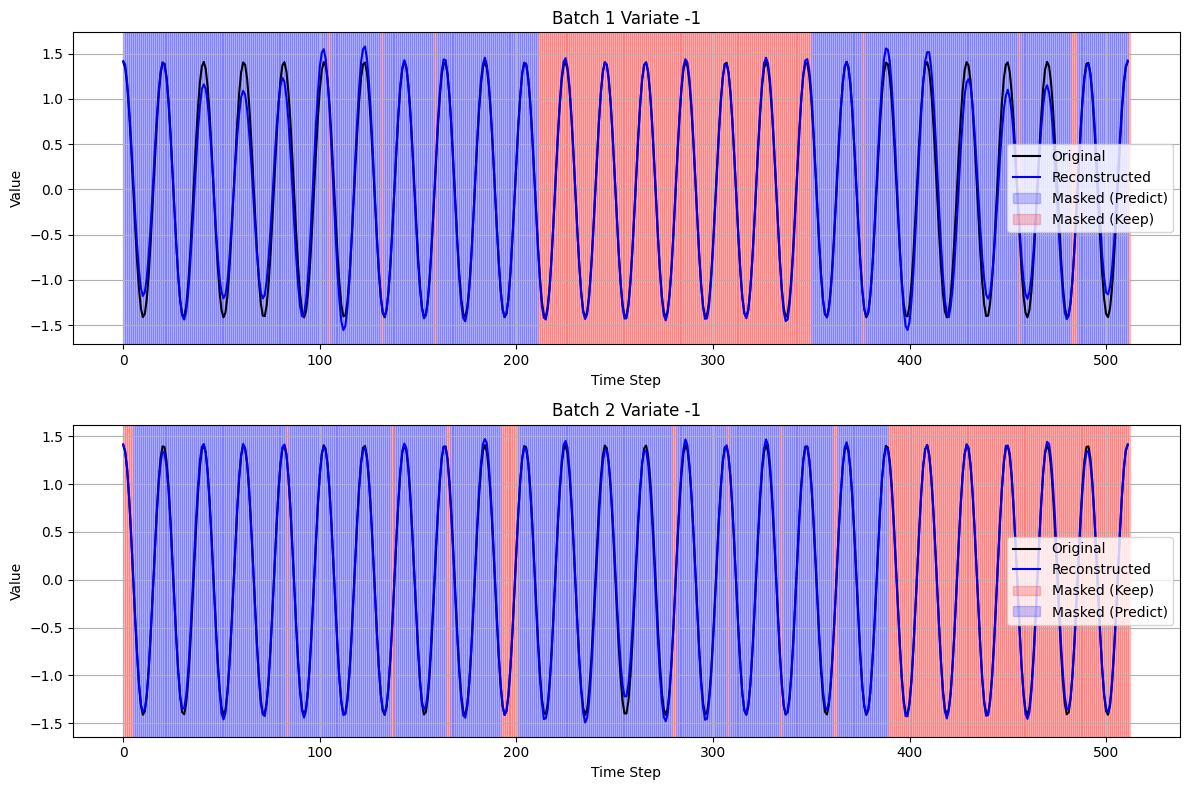

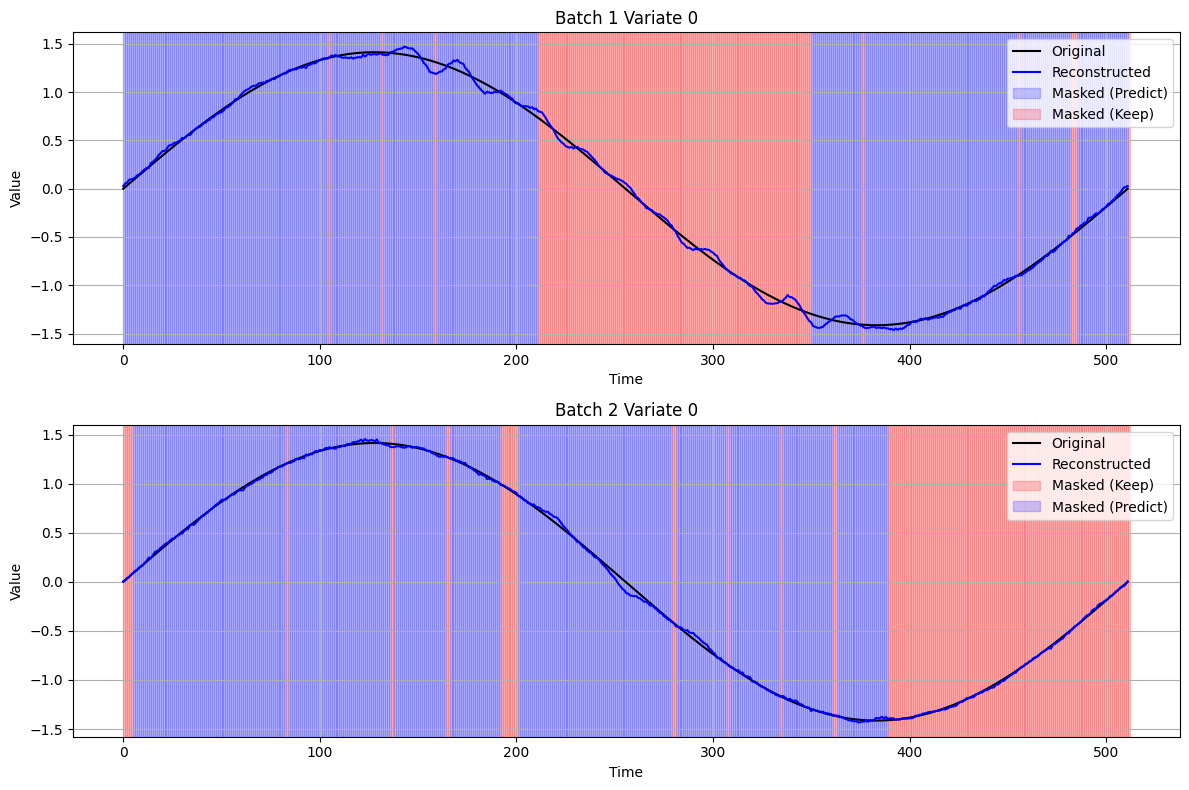

In [ ]:
trained_model.eval()
# Set feature_dim to the index of the last feature
feature_dim = -1

# with new random masking
# x_masked, mask = patch_masking(x, mask_ratio=0.75, patch_size= 2)

# with just x
# x_masked = x

out = trained_model(x_masked)

plt.figure(figsize=(12, 4 * batch_size))
for batch in range(batch_size):
    plt.subplot(batch_size, 1, batch + 1)
    plt.plot(x[batch, :, feature_dim].cpu().numpy(), label='Original', alpha=1, color="black")
    plt.plot(out[batch, :, feature_dim].detach().numpy(), label='Reconstructed', alpha=1, color="blue")

    mask_added_ax1 = False
    inv_mask_added_ax1 = False

    for t in range(sequence_length):
        if mask[batch, t] == 1:
            if not mask_added_ax1:
                plt.axvspan(t, t+1, color='red', alpha=0.2, label='Masked (Keep)')
                mask_added_ax1 = True
            else:
                plt.axvspan(t, t+1, color='red', alpha=0.2)
        else:
            if not inv_mask_added_ax1:
                plt.axvspan(t, t+1, color='blue', alpha=0.2, label='Masked (Predict)')
                inv_mask_added_ax1 = True
            else:
                plt.axvspan(t, t+1, color='blue', alpha=0.2)

    plt.legend()
    plt.title(f'Batch {batch+1} Variate -1')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4 * batch_size))
for batch in range(batch_size):
    plt.subplot(batch_size, 1, batch + 1)
    plt.plot(x[batch, :, 0].cpu().numpy(), label='Original', alpha=1, color="black")
    plt.plot(out[batch, :, 0].detach().numpy(), label='Reconstructed', alpha=1, color="blue")
    mask_added_ax1 = False
    inv_mask_added_ax1 = False

    for t in range(sequence_length):
        if mask[batch, t] == 1:
            if not mask_added_ax1:
                plt.axvspan(t, t+1, color='red', alpha=0.2, label='Masked (Keep)')
                mask_added_ax1 = True
            else:
                plt.axvspan(t, t+1, color='red', alpha=0.2)
        else:
            if not inv_mask_added_ax1:
                plt.axvspan(t, t+1, color='blue', alpha=0.2, label='Masked (Predict)')
                inv_mask_added_ax1 = True
            else:
                plt.axvspan(t, t+1, color='blue', alpha=0.2)

    plt.legend()
    plt.title(f'Batch {batch+1} Variate 0')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.grid(True)

plt.tight_layout()
plt.show()

# Trained Model Plot Enhanced Autoencoder

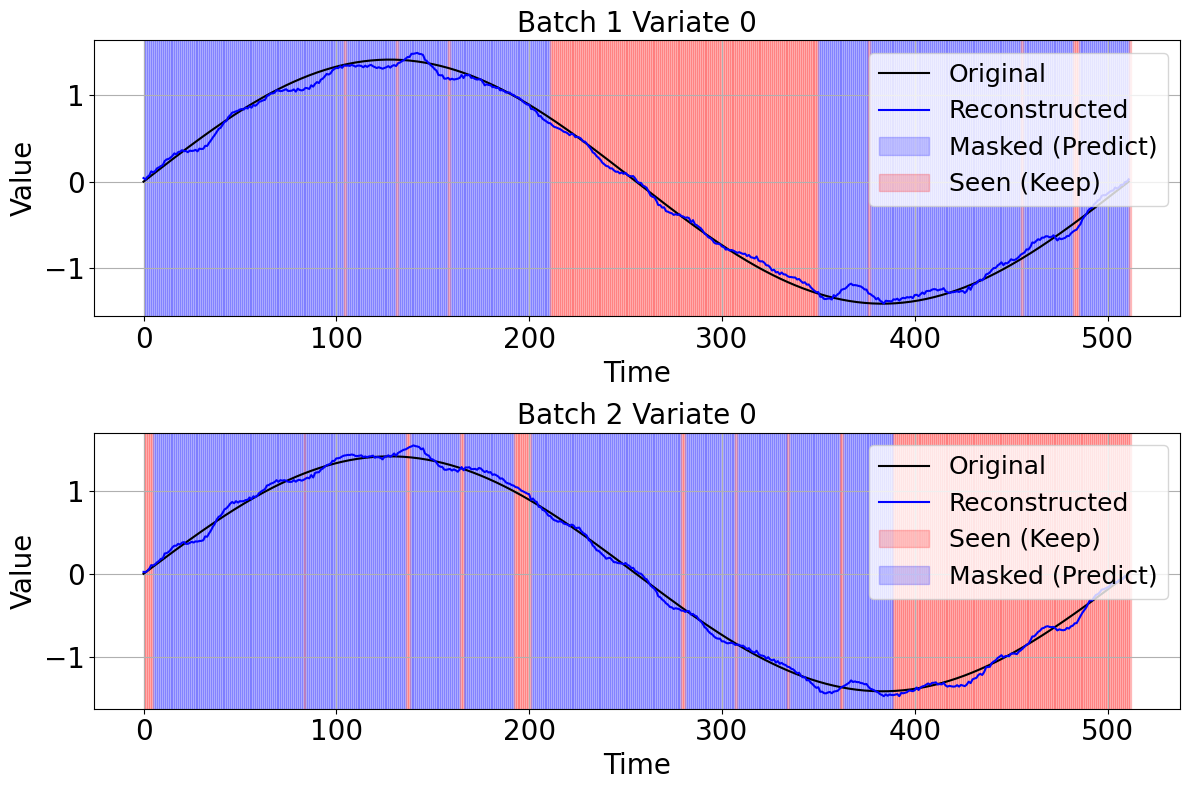

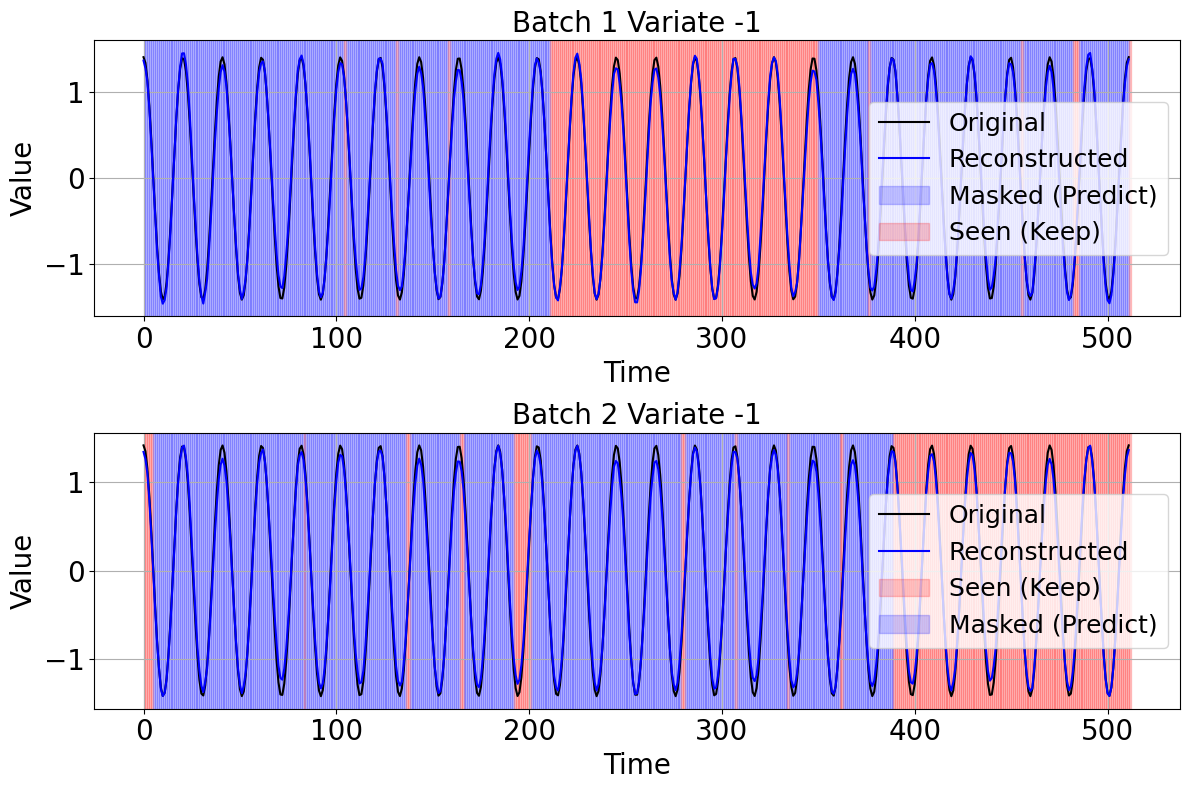

In [ ]:
trained_relu_model.eval()
feature_dim = -1

out = trained_relu_model(x_masked)

plt.figure(figsize=(12, 4 * batch_size))
for batch in range(batch_size):
    plt.subplot(batch_size, 1, batch + 1)

    # Plot original and reconstructed signals
    plt.plot(x[batch, :, 0].cpu().numpy(), label='Original', color="black")
    plt.plot(out[batch, :, 0].detach().numpy(), label='Reconstructed', color="blue")

    seen_label_added = False
    masked_label_added = False

    # Add highlighting for seen and masked areas
    for t in range(sequence_length):
        if mask[batch, t] == 1:
            if not seen_label_added:
                plt.axvspan(t, t+1, color='red', alpha=0.2, label='Seen (Keep)')
                seen_label_added = True
            else:
                plt.axvspan(t, t+1, color='red', alpha=0.2)
        else:
            if not masked_label_added:
                plt.axvspan(t, t+1, color='blue', alpha=0.2, label='Masked (Predict)')
                masked_label_added = True
            else:
                plt.axvspan(t, t+1, color='blue', alpha=0.2)

    plt.legend(fontsize=18)
    plt.title(f'Batch {batch+1} Variate 0', fontsize=20)
    plt.xlabel('Time', fontsize=20)
    plt.ylabel('Value', fontsize=20)
    plt.grid(True)
    plt.tick_params(axis='both', which='major', labelsize=20)

plt.tight_layout()
plt.show()

# Repeat for feature_dim
plt.figure(figsize=(12, 4 * batch_size))
for batch in range(batch_size):
    plt.subplot(batch_size, 1, batch + 1)
    plt.plot(x[batch, :, feature_dim].cpu().numpy(), label='Original', color="black")
    plt.plot(out[batch, :, feature_dim].detach().numpy(), label='Reconstructed', color="blue")

    seen_label_added = False
    masked_label_added = False

    for t in range(sequence_length):
        if mask[batch, t] == 1:
            if not seen_label_added:
                plt.axvspan(t, t+1, color='red', alpha=0.2, label='Seen (Keep)')
                seen_label_added = True
            else:
                plt.axvspan(t, t+1, color='red', alpha=0.2)
        else:
            if not masked_label_added:
                plt.axvspan(t, t+1, color='blue', alpha=0.2, label='Masked (Predict)')
                masked_label_added = True
            else:
                plt.axvspan(t, t+1, color='blue', alpha=0.2)

    plt.legend(fontsize=18)
    plt.title(f'Batch {batch+1} Variate -1', fontsize=20)
    plt.xlabel('Time', fontsize=20)
    plt.ylabel('Value', fontsize=20)
    plt.grid(True)
    plt.tick_params(axis='both', which='major', labelsize=20)

plt.tight_layout()
plt.show()


# Trained Model Plot Ensemble model
need to enamble the Ensemble model first and train it

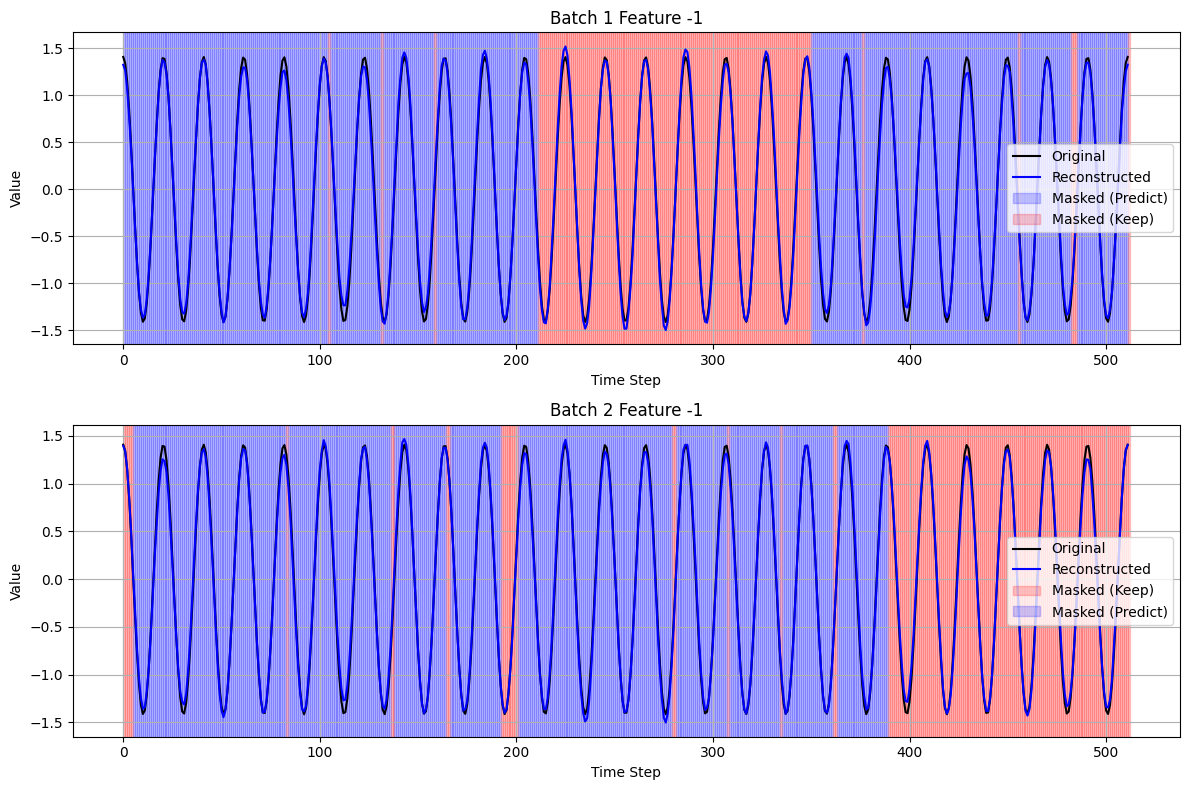

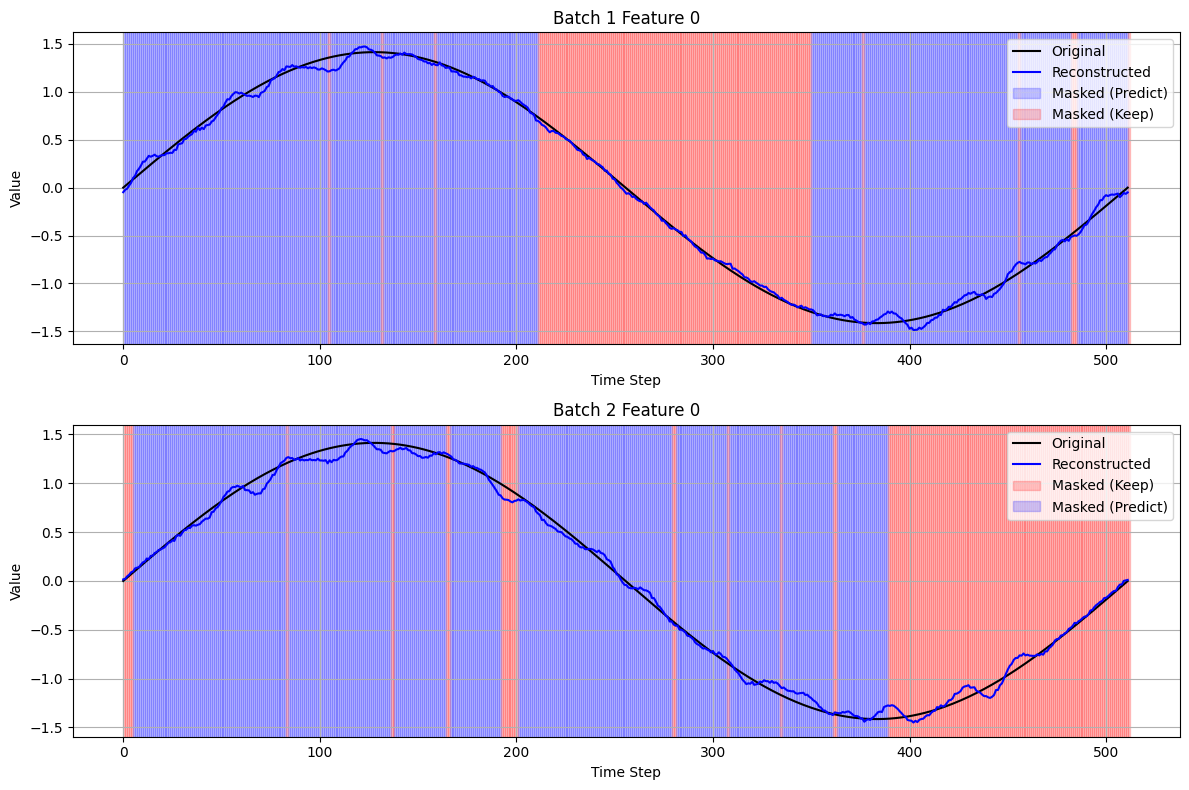

In [ ]:
trained_ensemble_model.eval()
# Set feature_dim to the index of the last feature
feature_dim = -1

# with new random masking
# x_masked, mask = patch_masking(x, mask_ratio=0.75, patch_size= 2)

# with just x
# x_masked = x

out = trained_ensemble_model(x_masked)

plt.figure(figsize=(12, 4 * batch_size))
for batch in range(batch_size):
    plt.subplot(batch_size, 1, batch + 1)
    plt.plot(x[batch, :, feature_dim].cpu().numpy(), label='Original', alpha=1, color="black")
    plt.plot(out[batch, :, feature_dim].detach().numpy(), label='Reconstructed', alpha=1, color="blue")

    mask_added_ax1 = False
    inv_mask_added_ax1 = False

    for t in range(sequence_length):
        if mask[batch, t] == 1:
            if not mask_added_ax1:
                plt.axvspan(t, t+1, color='red', alpha=0.2, label='Masked (Keep)')
                mask_added_ax1 = True
            else:
                plt.axvspan(t, t+1, color='red', alpha=0.2)
        else:
            if not inv_mask_added_ax1:
                plt.axvspan(t, t+1, color='blue', alpha=0.2, label='Masked (Predict)')
                inv_mask_added_ax1 = True
            else:
                plt.axvspan(t, t+1, color='blue', alpha=0.2)

    plt.legend()
    plt.title(f'Batch {batch+1} Feature -1')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4 * batch_size))
for batch in range(batch_size):
    plt.subplot(batch_size, 1, batch + 1)
    plt.plot(x[batch, :, 0].cpu().numpy(), label='Original', alpha=1, color="black")
    plt.plot(out[batch, :, 0].detach().numpy(), label='Reconstructed', alpha=1, color="blue")
    mask_added_ax1 = False
    inv_mask_added_ax1 = False

    for t in range(sequence_length):
        if mask[batch, t] == 1:
            if not mask_added_ax1:
                plt.axvspan(t, t+1, color='red', alpha=0.2, label='Masked (Keep)')
                mask_added_ax1 = True
            else:
                plt.axvspan(t, t+1, color='red', alpha=0.2)
        else:
            if not inv_mask_added_ax1:
                plt.axvspan(t, t+1, color='blue', alpha=0.2, label='Masked (Predict)')
                inv_mask_added_ax1 = True
            else:
                plt.axvspan(t, t+1, color='blue', alpha=0.2)

    plt.legend()
    plt.title(f'Batch {batch+1} Feature 0')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.grid(True)

plt.tight_layout()
plt.show()